# Ví dụ 1.  
(Dữ liệu tự tạo)  
200 mẫu, 2 lớp - mỗi lớp 100 mẫu, số chiều d = 2.  

## Data

Tạo data  

In [1]:
# generate data
# list of points
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(21)
from matplotlib.backends.backend_pdf import PdfPages
means = [[2, 2], [4, 1]]
cov = [[.3, .2], [.2, .3]]
N = 10
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X1[-1, :] = [2.7, 2]
X = np.concatenate((X0.T, X1.T), axis = 1)
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)

Trực quan hóa data

In [3]:
print(X0.shape, X1.shape, X.shape)

(10, 2) (10, 2) (2, 20)


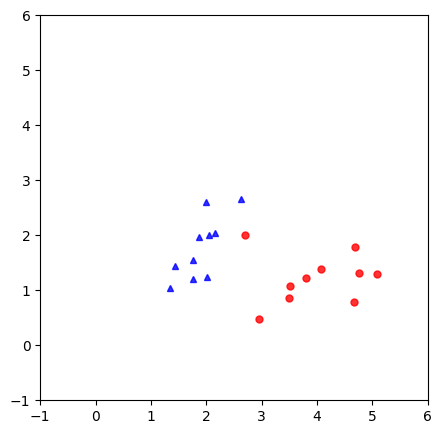

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
ani = plt.cla()
#plot points
ani = plt.plot(X0.T[0, :], X0.T[1, :], 'b^', markersize = 5, alpha = .8)
ani = plt.plot(X1.T[0, :], X1.T[1, :], 'ro', markersize = 5, alpha = .8)
ani = plt.axis([-1 , 6, -1, 6])
plt.show()

## Cách 1. Tự xây dựng các bước giải bài toán ràng buộc.  
Giải bài toán Lagrange đối ngẫu $g(\lambda)$ để tìm $\lambda$ sau đó tính $w, w_0$

Giải bài toán tối tưu: $- g(\lambda) \to min$   
Thực hiện tương tự như với HardMargin SVM, nhưng thêm ràng buộc chặn trên của các nhân tử Lagrange $(0 \leq \lambda \leq C)$

In [4]:
# !pip install cvxopt

  Using cached cvxopt-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.3 kB)
Using cached cvxopt-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.6 MB)


In [4]:
from cvxopt import matrix, solvers

C = 100
# build K
V = np.concatenate((X0.T, -X1.T), axis=1)
K = matrix(V.T.dot(V))
p = matrix(-np.ones((2 * N, 1)))
# build A, b, G, h
G = matrix(np.vstack((-np.eye(2 * N), np.eye(2 * N))))
h = matrix(np.vstack((np.zeros((2 * N, 1)), C * np.ones((2 * N, 1)))))
A = matrix(y.reshape((-1, 2 * N)))
b = matrix(np.zeros((1, 1)))
solvers.options["show_progress"] = False
sol = solvers.qp(K, p, G, h, A, b)
l = np.array(sol["x"])
print("lambda = \n", l.T)

lambda = 
 [[1.26997770e-08 7.29907090e-09 6.75263620e+00 1.20067067e-08
  8.83482181e-09 1.00135373e-08 9.49241066e-09 1.10095260e-08
  1.09448265e-08 1.15277180e+01 3.06483278e-09 2.92217775e-09
  3.52341246e-09 5.49363383e-09 4.48478627e-09 7.55953464e-09
  2.73325320e-09 5.71296652e-09 5.02756847e-09 1.82803543e+01]]


Tìm tập hợp những điểm support và những điểm nằm trên margins. Lọc ra các giá trị nhỏ hơn $10^{-6}$ sau đó tính $w, w_0$

In [5]:
y.reshape((-1, 2*N))

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1.]])

In [7]:
S = np.where(l > 1e-5)[0]  # support set
S2 = np.where(l < .999*C)[0]

M = [val for val in S if val in S2]  # intersection of two lists

XT = X.T  # we need each column to be one data point in this alg
VS = V[:, S]
lS = l[S]
yM = y[:, M]
XM = XT[M, :]

w_dual = VS.dot(lS).reshape(-1, 1)
b_dual = np.mean(yM.T - w_dual.T.dot(XM.T))
print(w_dual.T, b_dual)

[[-5.54276837  2.41628387]] 9.13290685085952


Trực quan hóa

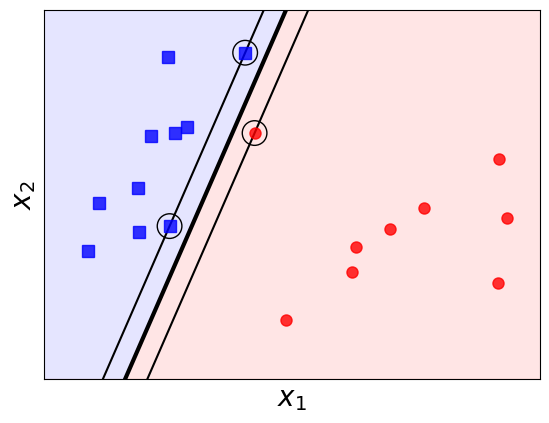

In [8]:
# draw
# plot points
fig, ax = plt.subplots()
x1 = np.arange(-10, 10, 0.1)
y1 = -w_dual[0, 0]/w_dual[1, 0]*x1 - b_dual/w_dual[1, 0]
y2 = -w_dual[0, 0]/w_dual[1, 0]*x1 - (b_dual-1)/w_dual[1, 0]
y3 = -w_dual[0, 0]/w_dual[1, 0]*x1 - (b_dual+1)/w_dual[1, 0]
plt.plot(x1, y1, 'k', linewidth=3)
plt.plot(x1, y2, 'k')
plt.plot(x1, y3, 'k')
y4 = 10*x1
plt.plot(x1, y1, 'k')
plt.fill_between(x1, y1, color='red', alpha=0.1)
plt.fill_between(x1, y1, y4, color='blue', alpha=0.1)
plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize=8, alpha=.8)
plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize=8, alpha=.8)
plt.axis('equal')
plt.ylim(0, 3)
plt.xlim(2, 4)
# hide tikcs
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
# add circles around support vectors
for m in S:
    circle = plt.Circle((X[0, m], X[1, m]), 0.1, color='k', fill=False)
    ax.add_artist(circle)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)
# plt.savefig('svm4.png', bbox_inches='tight', dpi = 300)
# pdf.savefig()
plt.show()

## Cách 2. Xây dựng phương pháp giải bài toán tối ưu không ràng buộc:  
Trong phương pháp này, chúng ta cần tính gradient của hàm mất mát. Để chắc chắn công thức tính gradient trong lý thuyết là đúng, chúng ta cần kiểm chứng này bằng cách so sánh với numerical gradient. 

Chú ý rằng trong phương pháp này, ta cần dùng tham số lam = 1/C (xem lại công thức lý thuyết).

In [9]:
X0_bar = np.vstack((X0.T, np.ones((1, N))))  # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N))))  # extended data

Z = np.hstack((X0_bar, - X1_bar))  # as in (22)
lam = 1./C


def cost(w):
    u = w.T.dot(Z)  # as in (23)
    # no bias
    return (np.sum(np.maximum(0, 1 - u)) + .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1]


def grad(w):
    u = w.T.dot(Z)  # as in (23)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = (-np.sum(ZS, axis=1, keepdims=True) + lam*w)
    g[-1] -= lam*w[-1]  # no weight decay on bias
    return g


eps = 1e-6


def num_grad(w):
    g = np.zeros_like(w)
    for i in range(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps
        wm[i] -= eps
        g[i] = (cost(wp) - cost(wm))/(2*eps)
    return g


w0 = np.random.randn(X0_bar.shape[0], 1)
g1 = grad(w0)
g2 = num_grad(w0)
diff = np.linalg.norm(g1 - g2)
print('Gradient different: %f' % diff)

Gradient different: 0.000000


Tiếp theo, chúng ta xây dựng phương thức lặp Gradient Descent và giải bài toán tối ưu để tìm tham số w, b:

In [10]:
def grad_descent(w0, eta):
    w = w0
    it = 0
    while it < 100000:
        it = it + 1
        g = grad(w)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' % it + ' cost: %f' % cost(w))
        if np.linalg.norm(g) < 1e-5:
            break
    return w


w0 = np.random.randn(X0_bar.shape[0], 1)
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]
print(w_hinge.T, b_hinge)

/tmp/ipykernel_188378/1039326824.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('iter %d' % it + ' cost: %f' % cost(w))


iter 1 cost: 87.184655
iter 10001 cost: 1.430915
iter 20001 cost: 1.092201
iter 30001 cost: 0.779892
iter 40001 cost: 0.491327
iter 50001 cost: 0.218693
iter 60001 cost: 0.183223
iter 70001 cost: 0.183222
iter 80001 cost: 0.183221
iter 90001 cost: 0.183220
[[-5.54923267  2.41881653]] [9.14508377]


## Cách 3. Sử dụng thư viện:

In [11]:
from sklearn.svm import SVC
# Copy and put code for generate data here
y1 = y.reshape((2*N,))
X1 = X.T  # each sample is one row
clf = SVC(kernel='linear', C=100)  # use the same C
# if C is small, method will be “SoftMagin SVM”,
# if C is large enough, method is near to hard margin
clf.fit(X1, y1)

w = clf.coef_
w0 = clf.intercept_
print('w = ', w)
print('b = ', w0)

w =  [[-5.54202362  2.4156074 ]]
b =  [9.13241559]


## Nhận xét kết quả:  
3 cách cho kết quả khá tương tự nhau

# Bài thực hành 1  
Sử dụng bộ trọng số W đã tính được và dự đoán các phân lớp y ứng với dữ liệu X  trên  chính  tập  dữ  liệu  ngẫu  nhiên  vừa  tạo. Đưa ra độ  chính  xác  Accuracy  và  ma  trận  nhầm  lẫn  Confusion Matrix theo mỗi phương pháp

In [12]:
y_pred = clf.predict(X1)
from sklearn.metrics import accuracy_score, confusion_matrix

print("Accuracy: ", accuracy_score(y1, y_pred))
print("Confusion matrix: \n", confusion_matrix(y1, y_pred))

Accuracy:  1.0
Confusion matrix: 
 [[10  0]
 [ 0 10]]


Nhận xét thấy cả 3 phương pháp đều có hệ số thu được tương tự nhau nên độ chính xác và ma trận nhầm lẫn cũng tương tự nhau. Sử dụng hàm có sẵn của thư viện ta thu được kết quả như trên.

# Bài thực hành 2

Sửa phần đọc dữ liệu trong Ví dụ 1 ở trên, sau đó áp dụng cho phần phân loại phân loại bệnh nhân ung thư vú của Đại học Wisconsin–Madison, Hoa Kỳ. Dữ liệu có sẵn trong thư viện sklearn.
Dữ liệu có 569 bản ghi (mẫu), với 30 thuộc tính. Bệnh nhân được chia làm hai loại: u lành tính (B – Begnin)
có 357 mẫu và u ác tính (M – Malignant) có 212 mẫu.
Đoạn chương trình thực hiện việc đọc dữ liệu như dưới đây:

In [9]:
from sklearn import datasets

cancer_data = datasets.load_breast_cancer()
# show to test record 5th
print(cancer_data.data[5])
print(cancer_data.data.shape)
# target set
print(set(cancer_data.target))

from sklearn.model_selection import train_test_split

cancer_data = datasets.load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer_data.data, cancer_data.target, test_size=0.3, random_state=109
)

[1.245e+01 1.570e+01 8.257e+01 4.771e+02 1.278e-01 1.700e-01 1.578e-01
 8.089e-02 2.087e-01 7.613e-02 3.345e-01 8.902e-01 2.217e+00 2.719e+01
 7.510e-03 3.345e-02 3.672e-02 1.137e-02 2.165e-02 5.082e-03 1.547e+01
 2.375e+01 1.034e+02 7.416e+02 1.791e-01 5.249e-01 5.355e-01 1.741e-01
 3.985e-01 1.244e-01]
(569, 30)
{0, 1}


Thực hiện các phương pháp SVM cho dữ liệu này.

## Cách 1. Tự xây dựng các bước giải bài toán ràng buộc  

In [43]:
#!pip install cvxopt
from cvxopt import matrix, solvers
C = 100
N = len(X_train)
# build K

# Calculate V
X0 = X_train[y_train == 0]
X1 = X_train[y_train == 1]
V = np.concatenate((X0.T, -X1.T), axis=1)
# V = X_train
K = matrix(V.T.dot(V))
p = matrix(-np.ones((N, 1)))

# build A, b, G, h
G = matrix(np.vstack((-np.eye(N), np.eye(N))))
h = matrix(np.vstack((np.zeros((N, 1)), C*np.ones((N, 1)))))
A = matrix(y_train.astype(float).reshape((-1, N)))  # y phải là float
b = matrix(np.zeros((1, 1)))
solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)
l = np.array(sol['x'])
print('lambda = \n', l.T)

lambda = 
 [[ 2.34837131e-16  1.54071427e-21 -1.14572257e-22  1.01377030e-21
   9.81492393e-22  5.14386652e-22  3.83818368e-22  1.41572935e-16
   1.00000000e+02  1.33112034e-21  2.65524476e-16  1.17980745e-21
  -9.12580982e-22  3.14552298e-17  1.68256094e-16  5.81062931e-17
   1.28346445e-16 -3.86127845e-22  9.14310702e-16  1.46119447e-21
   1.83514453e-16 -5.85128846e-22 -3.67279436e-22  1.33183518e-21
   1.53689591e-21  5.99737009e-16  3.04952684e-16  6.90753478e-22
   2.50325738e-17  1.75672787e-21  1.50302546e-21 -7.66609608e-22
  -6.65761891e-22  1.05384872e-21  1.98550444e-16  7.03430424e-22
   1.16648362e-15  1.79960786e-21  1.26208314e-16  7.11715442e-22
   4.13591190e-16 -6.22486112e-22  4.21491101e-16  1.15162924e-16
   1.00099665e-16  1.13043330e-16  4.79060083e-22 -2.22943209e-22
   2.63967792e-16  1.48379598e-21  6.78287471e+01  1.07893756e-21
   7.07105117e-01  1.25914146e-16  4.64608736e-22  1.79608834e+01
   1.64354821e-16  1.35940581e-21  1.91736346e-21  4.99569829e-22

In [61]:
l.shape

(398, 1)

Lọc bỏ các lambda xấp xỉ 0

In [51]:
S = np.where(l > 1e-5)[0] # support set
S2 = np.where(l < .999*C)[0]
M = [val for val in S if val in S2] # intersection of two lists
VS = V[:, S]
lS = l[S]
yM = y_train[M]
XM = X_train[M, :]
w_dual = VS.dot(lS).reshape(-1, 1)
b_dual = np.mean(yM.T - w_dual.T.dot(XM.T))
print(w_dual.T, b_dual)

[[-6.57075117e-01 -4.67958059e-01  2.35297916e-01 -1.08001847e-02
   2.92323675e+00 -1.66059977e+00  2.58602340e+00  5.10950940e+00
   3.10672544e+00 -1.04737650e+00  8.84052672e+00 -1.80602444e+00
   3.38613257e-01  4.78770819e-02  1.66953983e-01 -3.18467678e+00
  -2.60220812e+00  6.90328879e-01 -7.11385151e-01 -3.84833142e-01
  -2.54906449e+00  6.24668080e-01 -1.36602407e-01  4.12118753e-02
   4.24391826e+00 -3.40335184e+00  6.51488049e+00  7.51506678e+00
   1.14306689e+01 -1.99275500e+00]] -17.991013032573417


In [62]:
print(w_dual.shape, b_dual.shape)

(30, 1) ()


## Cách 2. Tự xây dựng các bước giải bài toán tối ưu không ràng buộc  

In [54]:
X0.shape

(149, 30)

In [55]:
X1.shape

(249, 30)

In [56]:
X0_bar = np.vstack((X0.T, np.ones((1, len(X0)))))  # extended data
X1_bar = np.vstack((X1.T, np.ones((1, len(X1)))))  # extended data
Z = np.hstack((X0_bar, -X1_bar))  # as in (22)
lam = 1.0 / C


def cost(w):
    u = w.T.dot(Z)  # as in (23)
    return (np.sum(np.maximum(0, 1 - u)) + 0.5 * lam * np.sum(w * w)) - 0.5 * lam * w[
        -1
    ] * w[
        -1
    ]  # no bias


def grad(w):
    u = w.T.dot(Z)  # as in (23)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = -np.sum(ZS, axis=1, keepdims=True) + lam * w
    g[-1] -= lam * w[-1]  # no weight decay on bias
    return g


eps = 1e-6


def num_grad(w):
    g = np.zeros_like(w)
    for i in range(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps
        wm[i] -= eps
        g[i] = (cost(wp) - cost(wm)) / (2 * eps)
    return g


w0 = np.random.randn(X0_bar.shape[0], 1)
g1 = grad(w0)
g2 = num_grad(w0)
diff = np.linalg.norm(g1 - g2)
print("Gradient different: %f" % diff)

Gradient different: 0.000053


Dùng phương pháp lặp GD và giải tìm tham số w, b

In [57]:
def grad_descent(w0, eta):
    w = w0
    it = 0
    while it < 100000:
        it = it + 1
        g = grad(w)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' %it + ' cost: %f' %cost(w))
        if np.linalg.norm(g) < 1e-5:
            break
    return w
    
w0 = np.random.randn(X0_bar.shape[0], 1)
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]
print(w_hinge.T, b_hinge)

/tmp/ipykernel_7764/714090710.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('iter %d' %it + ' cost: %f' %cost(w))


iter 1 cost: 47552024.006693
iter 10001 cost: 936445.736055
iter 20001 cost: 883001.301455
iter 30001 cost: 848293.353281
iter 40001 cost: 528487.466579
iter 50001 cost: 616058.394890
iter 60001 cost: 610795.016209
iter 70001 cost: 1137983.181283
iter 80001 cost: 960895.327562
iter 90001 cost: 636284.723232
[[-8.45158936e+02 -1.63970559e+02 -2.32116518e+03 -6.45811114e+01
   1.53461777e+01  8.53609352e+01  1.26657806e+02  5.27593331e+01
   2.31124834e+01  3.78736228e+00 -2.67194792e+01 -7.25198436e+01
   1.43798548e+02  4.42931335e+02  2.37716283e+00  2.29065633e+01
   3.16146571e+01  7.75840816e+00  4.56987700e+00  2.18472084e+00
  -9.14330376e+02  1.43855644e+03 -4.78266904e+01  2.51863500e+02
   3.05342955e+01  2.90597817e+02  3.71684620e+02  1.04568396e+02
   7.65213954e+01  2.64020676e+01]] [-190.58458415]


In [63]:
print(w_hinge.shape, b_hinge.shape)

(30, 1) (1,)


## Cách 3. Sử dụng thư viện  

In [60]:
from sklearn.svm import SVC
# Copy and put code for generate data here
y = y_train.reshape((len(X_train),))
X = X_train # each sample is one row
clf = SVC(kernel = 'linear', C = 100) # use the same C# if C is small, method will be “SoftMagin SVM”,
# if C is large enough, method is near to hard margin
clf.fit(X, y)
w = clf.coef_
w0 = clf.intercept_
print('w = ', w)
print('b = ', w0)

w =  [[ 2.10521703e+01  2.24748145e+00 -1.77289349e+00  9.15961285e-03
  -7.50191176e+00 -4.34135787e+00 -2.25615054e+01 -1.61915144e+01
  -1.98778957e+01  5.08582561e-01 -5.57421178e+00  3.81134662e+01
  -3.92641821e+00 -1.62481829e+00 -1.18075404e+00  4.61362107e+00
  -2.22012902e+00 -3.35024278e+00 -5.99961794e+00  4.40746425e-01
   7.64789045e+00 -6.07125487e+00  2.54343023e-01 -2.28638946e-01
  -1.32196366e+01  1.01949935e+01 -4.05023898e+01 -3.32636055e+01
  -6.20170725e+01  1.96239376e+00]]
b =  [71.50072957]


In [64]:
print(w.shape, w0.shape)

(1, 30) (1,)


## Nhận xét kết quả  

Bộ trọng số của cách 1:  
w = [[-6.57075117e-01 -4.67958059e-01  2.35297916e-01 -1.08001847e-02
   2.92323675e+00 -1.66059977e+00  2.58602340e+00  5.10950940e+00
   3.10672544e+00 -1.04737650e+00  8.84052672e+00 -1.80602444e+00
   3.38613257e-01  4.78770819e-02  1.66953983e-01 -3.18467678e+00
  -2.60220812e+00  6.90328879e-01 -7.11385151e-01 -3.84833142e-01
  -2.54906449e+00  6.24668080e-01 -1.36602407e-01  4.12118753e-02
   4.24391826e+00 -3.40335184e+00  6.51488049e+00  7.51506678e+00
   1.14306689e+01 -1.99275500e+00]]  
b = [-17.991013032573417]  
  
Bộ trọng số của cách 2:  
w = [[-8.45158936e+02 -1.63970559e+02 -2.32116518e+03 -6.45811114e+01
   1.53461777e+01  8.53609352e+01  1.26657806e+02  5.27593331e+01
   2.31124834e+01  3.78736228e+00 -2.67194792e+01 -7.25198436e+01
   1.43798548e+02  4.42931335e+02  2.37716283e+00  2.29065633e+01
   3.16146571e+01  7.75840816e+00  4.56987700e+00  2.18472084e+00
  -9.14330376e+02  1.43855644e+03 -4.78266904e+01  2.51863500e+02
   3.05342955e+01  2.90597817e+02  3.71684620e+02  1.04568396e+02
   7.65213954e+01  2.64020676e+01]]  
b = [-190.58458415]  
  
Bộ trọng số của cách 3:  
w = [[ 2.10521703e+01  2.24748145e+00 -1.77289349e+00  9.15961285e-03
  -7.50191176e+00 -4.34135787e+00 -2.25615054e+01 -1.61915144e+01
  -1.98778957e+01  5.08582561e-01 -5.57421178e+00  3.81134662e+01
  -3.92641821e+00 -1.62481829e+00 -1.18075404e+00  4.61362107e+00
  -2.22012902e+00 -3.35024278e+00 -5.99961794e+00  4.40746425e-01
   7.64789045e+00 -6.07125487e+00  2.54343023e-01 -2.28638946e-01
  -1.32196366e+01  1.01949935e+01 -4.05023898e+01 -3.32636055e+01
  -6.20170725e+01  1.96239376e+00]]  
b =  [71.50072957]  



Bộ trọng số cách 3 là khá tốt (chạy từ thư viện với độ chính xác cao), tuy nhiên bộ trọng số của cách 1 và 2 khác khá nhiều với cách 3 nên có thể do cách 1 và cách 2 setup chưa đủ tốt.

# Ví dụ 2.  
(Dữ liệu sóng thủy âm Sonar)

## Đọc dữ liệu

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

# Đọc dữ liệu từ tệp CSV
data = pd.read_csv("data/sonar.csv", header=None)

In [2]:
# Chuyển đổi nhãn "M" thành 1 và nhãn "R" thành -1
data[60] = data[60].apply(lambda x: 1 if x == "M" else -1)

# Tách dữ liệu thành features (X) và nhãn (y)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [3]:
# Tách dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Dùng SVM SoftMargin

In [4]:
# Huấn luyện mô hình SVM với hard margin
model = SVC(kernel='linear', C=0.1)
model.fit(X_train, y_train)


SVC(C=0.1, kernel='linear')

## Kiểm tra trên train và test

In [5]:
# Đánh giá mô hình trên tập kiểm tra
y_pred_train = model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Accuracy:", accuracy_train)

Accuracy: 0.7650602409638554


In [6]:
# Đánh giá mô hình trên tập kiểm tra
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8571428571428571


Confusion Matrix:
[[15  1]
 [ 5 21]]


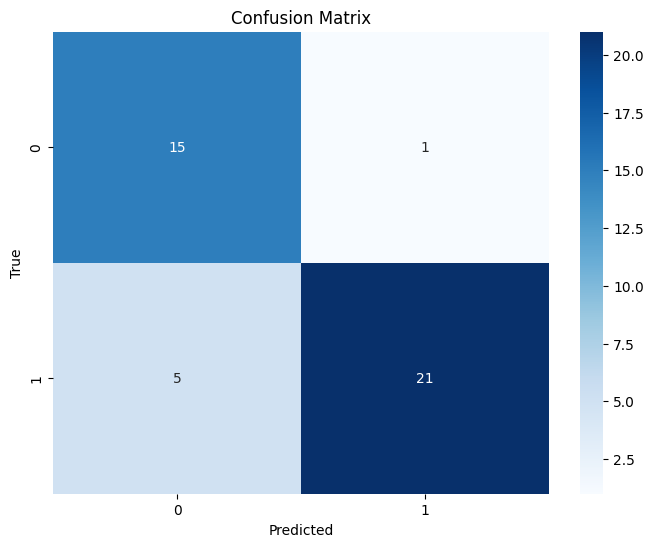

In [8]:
import matplotlib.pyplot as plt 

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Trực quan hóa ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Giải thích kết quả  
Độ chính xác trên tập train không còn là 1 như hard margin. Tuy nhiên đem đến kết quả tốt hơn trên tập test khi so với hard margin. Như vậy có thể thấy hard margin dễ bị over fit hơn so với soft margin 

# Ví dụ 3  
(Lọc thư rác)

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

# Load data
# url = "http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
# data = pd.read_csv(url, header=None)
data = pd.read_csv("data/spambase/spambase.data", header=None)

# Assign column names
column_names = [
    "word_freq_make",
    "word_freq_address",
    "word_freq_all",
    "word_freq_3d",
    "word_freq_our",
    "word_freq_over",
    "word_freq_remove",
    "word_freq_internet",
    "word_freq_order",
    "word_freq_mail",
    "word_freq_receive",
    "word_freq_will",
    "word_freq_people",
    "word_freq_report",
    "word_freq_addresses",
    "word_freq_free",
    "word_freq_business",
    "word_freq_email",
    "word_freq_you",
    "word_freq_credit",
    "word_freq_your",
    "word_freq_font",
    "word_freq_000",
    "word_freq_money",
    "word_freq_hp",
    "word_freq_hpl",
    "word_freq_george",
    "word_freq_650",
    "word_freq_lab",
    "word_freq_labs",
    "word_freq_telnet",
    "word_freq_857",
    "word_freq_data",
    "word_freq_415",
    "word_freq_85",
    "word_freq_technology",
    "word_freq_1999",
    "word_freq_parts",
    "word_freq_pm",
    "word_freq_direct",
    "word_freq_cs",
    "word_freq_meeting",
    "word_freq_original",
    "word_freq_project",
    "word_freq_re",
    "word_freq_edu",
    "word_freq_table",
    "word_freq_conference",
    "char_freq_;",
    "char_freq_(",
    "char_freq_[",
    "char_freq_!",
    "char_freq_$",
    "char_freq_#",
    "capital_run_length_average",
    "capital_run_length_longest",
    "capital_run_length_total",
    "spam",
]
data.columns = column_names

# Split features and target
X = data.drop(columns=["spam"]).values
y = np.where(data["spam"].values == 1, 1, -1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Train the SVM model with soft margin
model = SVC(kernel="linear", C=0.1)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.9239681390296887

Confusion Matrix:
[[767  37]
 [ 68 509]]
